[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/tobyrmanders/statistical-rethinking/blob/main/code/chapter_04.ipynb)

In [189]:
import torch
from torch import tensor
import torch.distributions.constraints as constraints

import pyro
from pyro import distributions as dist
from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.infer import svi
from pyro import optim
import pyro.ops.stats as stats


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rethinking import MAP, coef, extract_samples, link, precis, sim, vcov

# 4E1

yi ∼ Normal(µ, σ) 

# 4E2

2

# 4E3

$
P(\mu, \sigma|y) = \frac{\prod_i \text{Normal}(y_i|\mu,\sigma) \text{Normal}(\mu|0,10) \text{Exponential}(\sigma|1)}{\int\int\prod_i \text{Normal}(y_i|\mu,\sigma) \text{Normal}(\mu|0,10) \text{Exponential}(\sigma|1)d\mu d\sigma}
$

# 4E4

$\mu_i = \alpha + \beta x_i$

# 4E5

3

# 4M1

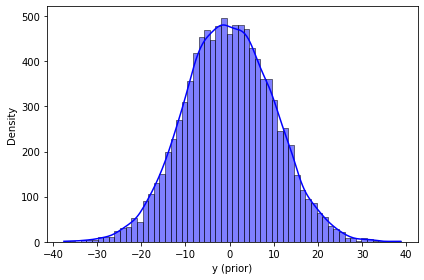

In [23]:
n_samples = 10_000
sample_mu = dist.Normal(tensor(0.), tensor(10.)).sample(torch.Size([n_samples]))
sample_sigma = dist.Exponential(tensor(1.),).sample(torch.Size([n_samples]))
prior_y = dist.Normal(sample_mu, sample_sigma).sample()
fig, ax = plt.subplots()
sns.histplot(prior_y.numpy(), color='blue', kde=True, ax=ax)
ax.set_xlabel('y (prior)')
ax.set_ylabel('Density')
fig.tight_layout()

<AxesSubplot:ylabel='Count'>

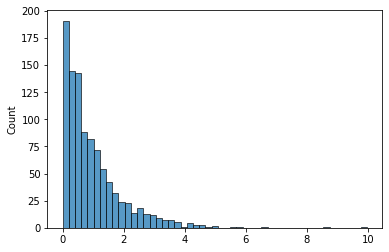

In [21]:
sns.histplot(sample_sigma)

# 4M2

In [265]:
# pyro model definition
pyro.clear_param_store()
def model_4m3(data=None, N=None):
    mu = pyro.sample('mu', dist.Normal(tensor(0.), tensor(10.)))
    sigma = pyro.sample('sigma', dist.Exponential(tensor(1.),))
    if N is None:
        N = 1 if data is None else len(data)
    with pyro.plate('data', N):
        y = pyro.sample('y', dist.Normal(mu, sigma), obs=data)
        return y

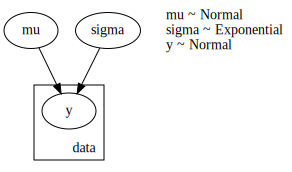

In [266]:
pyro.render_model(model_4m3, render_distributions=True, render_params=True)

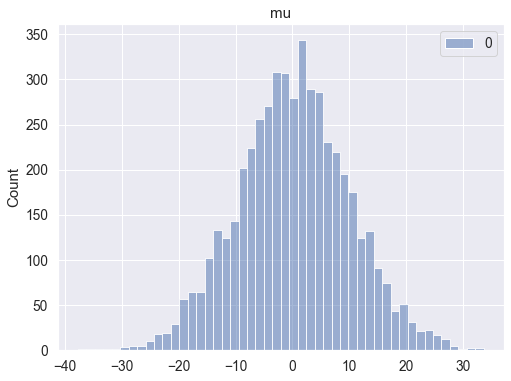

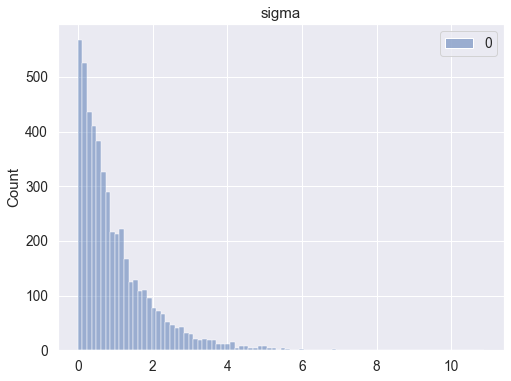

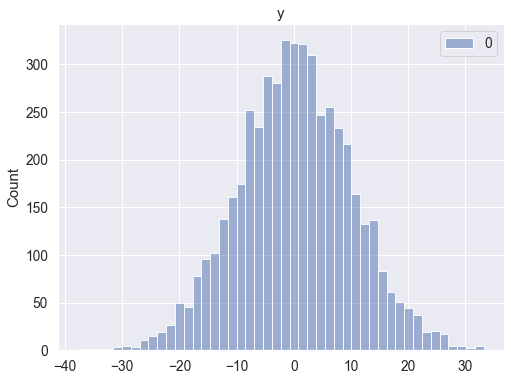

In [258]:
# prior predictive distribution
from pyro.infer import Predictive

x = model_4m3
prior_predictive = Predictive(model_4m3, {}, num_samples=5000)()
for site, values in prior_predictive.items():
    ax = sns.histplot(values)
    ax.set_title(site)
    plt.show()

# 4M3

mathematical model definition

$
y_i \sim \text{Normal}(\mu, \sigma)\newline
\mu_i = a + b*x_i\newline
a \sim \text{Normal}(0, 10)\newline
b \sim \text{Uniform}(0, 1)\newline
\sigma \sim \text{Exponential}(1)\newline
$

# 4M4

$
height_i \sim \text{Normal}(\mu, \sigma)\newline
\mu_i = a + b*year_i\newline
a \sim \text{Normal}(160, 50)\newline
b \sim \text{Normal}(10, 5)\newline
\sigma \sim \text{Exponential}(1)\newline
$

In [47]:
dist.Uniform(1990, 2000).sample(torch.Size([5])).int()

tensor([1992, 1990, 1997, 1994, 1990], dtype=torch.int32)

<AxesSubplot:ylabel='Count'>

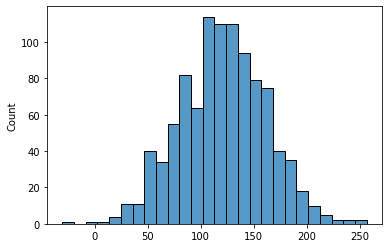

In [65]:
# intercept prior
a = dist.Normal(tensor(120.), tensor(40.)).sample(torch.Size([1000]))
sns.histplot(a)

<AxesSubplot:ylabel='Count'>

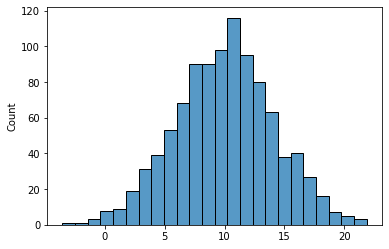

In [67]:
# slope prior
b = dist.Normal(tensor(10.), tensor(4.)).sample(torch.Size([1000]))
sns.histplot(b)

<AxesSubplot:ylabel='Count'>

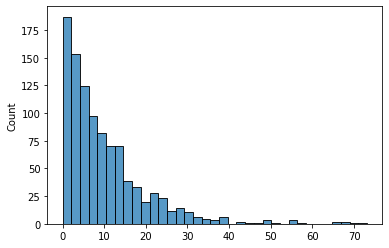

In [113]:
# slope prior
sigma = dist.Exponential(tensor(0.1)).sample(torch.Size([1000]))
sns.histplot(sigma)

In [123]:
def model_4m4(year=None, height=None, N=None):
    
    if year is not None:
        assert height is not None
        assert len(year)==len(height)
        assert isinstance(year, int)
        
    a = pyro.sample('a', dist.Normal(tensor(120.), tensor(40.)))
    b = pyro.sample('b', dist.Normal(tensor(10.), tensor(4.)))
    sigma = pyro.sample('sigma', dist.Exponential(tensor(.1),))
    
    if N is None:
        N = 1 if year is None else len(year)
        
    with pyro.plate('data_loop', N):
        year = pyro.sample('year', dist.Uniform(0, 10), obs=year).int()
#         print(year)
        mu = a + b * year
#         print(mu)
        height = pyro.sample('height', dist.Normal(mu, sigma), obs=height)
#         print(height)
        return year, height

In [124]:
# generate samples
pyro.clear_param_store()
year_samples, height_samples = model_4m4(N=2000)
print(f"{year_samples[:10]=}")
print(f"{height_samples[:10]=}")

year_samples[:10]=tensor([8, 8, 5, 9, 6, 2, 5, 5, 6, 0], dtype=torch.int32)
height_samples[:10]=tensor([283.0759, 298.9780, 224.5552, 300.6707, 249.4370, 175.2711, 235.8163,
        226.0534, 253.9278, 146.9803])


<AxesSubplot:>

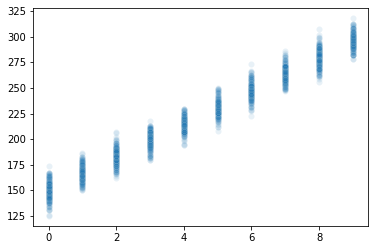

In [127]:
sns.scatterplot(x=year_samples, y=height_samples, alpha=0.1)

# 4M5

See prior above. Slope could be constrained to positive values. Could use half-Cauchy or half-Normal prior. 

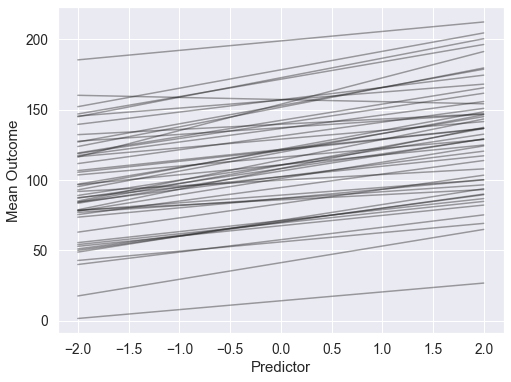

In [269]:
import numpy as np

# check that slope is positive
prior_predictive = Predictive(model_4m4, {}, num_samples=50)() 

def plot_predictive(prior_predictive):
    _, ax = plt.subplots()

    x = np.linspace(-2, 2, 50)

    for a, b in zip(prior_predictive["a"], prior_predictive["b"]):
        y = a + b * x
        ax.plot(x, y, c="k", alpha=0.4)

    ax.set_xlabel("Predictor")
    ax.set_ylabel("Mean Outcome")
    
plot_predictive(prior_predictive)

# 4M6

Sigma priors should be constrained to values uner sqrt(64) = 8.

<AxesSubplot:ylabel='Count'>

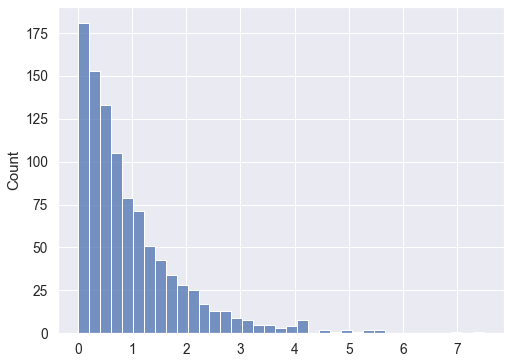

In [276]:
# check that this is already true
sns.histplot(dist.Exponential(1).sample(torch.Size([int(1e3)])))

# 4M7

In [287]:
howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = howell1
d2 = d[d["age"] >= 18]

weight_c = d2.weight - d2.weight.mean()

pyro.clear_param_store()
def model(weight=None, height=None):
    a = pyro.sample("a", dist.Normal(178, 20))
    b = pyro.sample("b", dist.LogNormal(0, 1))
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    with pyro.plate("data"):
        mu = a + b * weight 
        h = pyro.sample("height", dist.Normal(mu, sigma), obs=height)
        return h

d2_weight = torch.tensor(d2["weight"], dtype=torch.float)
d2_weight_c = torch.tensor(weight_c, dtype=torch.float)
d2_height = torch.tensor(d2["height"], dtype=torch.float)
m4_3 = MAP(model).run(d2_weight, d2_height)

In [288]:
precis(m4_3, corr=True)

,Mean,StdDev,|0.89,0.89|,a,b,sigma
a,186.90,4.85,178.91,194.42,1.00,-0.32,0.82
b,0.77,0.04,0.71,0.82,-0.32,1.00,0.01
sigma,41.74,1.29,39.63,43.69,0.82,0.01,1.00


In [289]:
print(vcov(m4_3).diag())
cov = vcov(m4_3)
print(cov / cov.diag().ger(cov.diag()).sqrt())

tensor([2.3488e+01, 1.2287e-03, 1.6574e+00])
tensor([[ 1.0000, -0.3210,  0.8226],
        [-0.3210,  1.0000,  0.0068],
        [ 0.8226,  0.0068,  1.0000]])


In [290]:
prior_samples = Predictive(model, {}, num_samples=50)()
plot_predictive(prior_samples)

TypeError: unsupported operand type(s) for *: 'Tensor' and 'NoneType'

# 4M8
Code example for splines not available. Probably need to implement from scratch. 
https://docs.pyro.ai/en/stable/_modules/pyro/distributions/transforms/spline.html

# 4H1

In [199]:
weights = torch.tensor([46.95, 43.72, 64.78, 32.59, 54.63])
pred_heights = sim(m4_3, data={'weight': weights})

In [200]:
pred_heights.shape

torch.Size([1000, 5])

In [203]:
height_mean = pred_heights.mean(0)
height_mean

tensor([247.8079, 244.6785, 262.1838, 233.8176, 253.1528])

In [201]:
height_PI = stats.pi(pred_heights, prob=0.89, dim=0)

In [202]:
height_PI

tensor([[186.0733, 181.8310, 201.0557, 174.0015, 192.1495],
        [305.6400, 310.0035, 324.4444, 291.4416, 312.2299]])

# 4H2

In [246]:
howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = howell1
d2 = d[d["age"] < 18]

def model(weight, height):
    a = pyro.sample("a", dist.Normal(100, 100))
    b = pyro.sample("b", dist.Normal(0, 10))
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(a + b * weight, sigma), obs=height)

m4h2 = MAP(model).run(d2_weight, d2_height)

In [247]:
precis(m4h2, corr=True)

,Mean,StdDev,|0.89,0.89|,a,b,sigma
a,111.84,13.92,89.49,133.72,1.00,-0.94,-0.01
b,-2.67,0.32,-3.19,-2.16,-0.94,1.00,-0.30
sigma,37.25,0.51,36.43,38.05,-0.01,-0.30,1.00


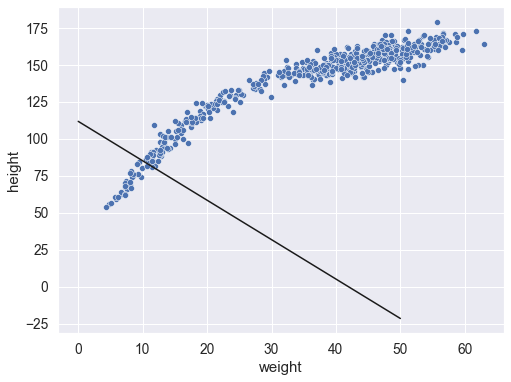

In [248]:
sns.scatterplot("weight", "height", data=d)
x = torch.linspace(0, 50, 101)
sns.lineplot(x, (coef(m4h2)["a"] + coef(m4h2)["b"] * x), color="k");